# Feature & Target Pipeline
Quick smoke test that mirrors production: build features, derive targets, combine them, and prepare time-based splits.

In [1]:
import pandas as pd
from pathlib import Path
from typing import Optional

from data_pipeline import load_data  # This just loads the data and cleans it

from featureEngineer import FeatureEngineer
from targetEngineer import ExpirationTargetEngineer

from ML_setup import CONFIG
from ML_general_tools import *
from pathlib import Path

print("Imports and configuration ready")

# Build features, targets, and combined dataframe
raw_history = load_data(CONFIG["data"]["path"])
history_slice = raw_history[-1000:]


feature_params = dict(CONFIG["features"]["params"])
heavy_cache_cfg = CONFIG["features"].get("heavy_cache", {})
heavy_cache_root = Path(heavy_cache_cfg.get("directory", "cache/heavy_features"))

current_output_root_str = CONFIG["output"]["directory"]
current_output_root_path = Path(current_output_root_str)

paths = {
    "root": current_output_root_path,
    "feature_selection": current_output_root_path / CONFIG["output"]["subdirectories"]["features"],
    "trained_models": current_output_root_path / CONFIG["output"]["subdirectories"]["models"],
    "hpt_studies": current_output_root_path / CONFIG["output"]["subdirectories"]["hpt"],
    "feature_cache": current_output_root_path / CONFIG["output"]["subdirectories"]["cache"]
}


cache_dir = heavy_cache_root
cache_dir.mkdir(parents=True, exist_ok=True)
cache_files = sorted(cache_dir.glob("heavy_features_v*.pkl"))
cache_ready = bool(cache_files)
if cache_ready:
    print(f"Heavy cache ready: {cache_files[-1].name} (total {len(cache_files)}) in {cache_dir}")
else:
    print(f"No heavy cache file found in {cache_dir}; initial fit will populate.")

# existing_fe: Optional[FeatureEngineer] = None
# if "feature_engineer" in globals() and isinstance(feature_engineer, FeatureEngineer):
#     existing_fe = feature_engineer

# if existing_fe is not None:
#     print("Reusing existing FeatureEngineer instance.")
#     fe = existing_fe
# else:
#     print("Instantiating new FeatureEngineer instance.")
#     fe = FeatureEngineer(verbose=feature_params.get("verbose", False), **{k: v for k, v in feature_params.items() if k != "verbose"})

fe = FeatureEngineer(verbose=feature_params.get("verbose", False), **{k: v for k, v in feature_params.items() if k != "verbose"})


cache_ready = False  # Force rebuild for testing

manual_features = None
if cache_ready and fe.heavy_cache.load():
    print("Loaded heavy cache payload from disk; skipping rebuild.")
    fe._heavy_payload = fe.heavy_cache.payload
    reference = fe._prepare_reference_frame(history_slice)
    fe._full_reference = reference
    manual_features = fe._compute_all_features(reference, build_heavy=False)
    fe.feature_names_out_ = manual_features.columns.tolist()
    fe._reference_features = manual_features
else:
    print("Heavy cache not available or failed to load; running full fit.")
    verbose_flag = feature_params.pop("verbose", False)
    fe = FeatureEngineer(verbose=verbose_flag, **feature_params)
    fe.fit(history_slice)
    manual_features = fe.transform(history_slice)

feature_engineer = fe
features = manual_features.copy()

## Add tarrgets
target_engineer = ExpirationTargetEngineer(**CONFIG["targets"]["params"])
target_engineer.fit(features)
targets = target_engineer.transform(features)



# --- 2b. Adding Derived Probability Features (from pre-trained models) ---
derived_proba_config = CONFIG["features"].get("derived_probability_features", {})
print(f'derived_proba_config: {derived_proba_config}')
if derived_proba_config.get("enabled", False):
    print("\n2b. Adding Derived Probability Features")
    features, newly_added_proba_features = generate_and_add_derived_probability_features(
        features.copy(),
        derived_proba_config,
        paths
    )
    if newly_added_proba_features:
        print(f"  Successfully added derived probability features: {newly_added_proba_features}")
        # Check for NaNs in each new feature
        for feat in newly_added_proba_features:
            if feat in features.columns:
                n_nans = features[feat].isna().sum()
                print(f"    [NaN check] {feat}: {n_nans} NaNs ({n_nans/len(features):.2%} of rows)")
            else:
                print(f"    [NaN check] {feat}: not found in features DataFrame!")
    else:
        print("  No new derived probability features were added (or generation was disabled).")

initial_feature_names = list(features.columns)

# Generate targets (your existing logic)
print(initial_feature_names)


## deop pice columns from features
# drop_cols = [col for col in ['o', 'h', 'l', 'c'] if col in features.columns]
# if drop_cols: features = features.drop(columns=drop_cols)




/home/east/shared/eastSync/pyEast/pro_version/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports and configuration ready
=== Loading .hist_db_1h.csv ===

Initial rows: 53,963

=== FOUND ISSUES (prior to automated fixes) ===

🔴 TEMPORAL: Missing hours: 1 cases
  Missing timestamps sample:
    2025-11-04 13:00:00

🔴 DATA INTEGRITY: Identical consecutive OHLC rows: 174 cases
  Sample cases:
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
  Affected dates (sample): 2020-01-02, 2020-01-03, 2020-01-04, 2020-01-05, 2020-01-06

=== APPLYING AUTOMATED FIXES ===
ACTION: Resampled/Reindexed to 53964 hourly intervals (was 53963).
ACTION: Forward-filled NaNs after resampling. (5 NaNs potentially filled by ffill).

=== FINAL STATUS (after automated fixes) ===
DataFrame shape post-fixes: (53964, 5) (Original: (53963, 6))
Date range: 2019-10-01 00:00:00 to 2025-11-26 11:00:00
No 

In [10]:
from targetEngineer import VolatilityRegimeEngineer
df_train = features.copy()


regime_engineer = VolatilityRegimeEngineer(
    lookback_window=24*3,    # 1 week for deseasonalized vol
    seasonal_window=24*30,    # 30 days to learn patterns
    forward_window=24,      # 12h forward classification
    trend_std=1.2,
    jump_std=3,
    jump_speed_window=6,  # Jump must occur within 3 time units

    # 0.25 is a good baseline.
    # > 0.40 means "Very clean, almost straight line trends only"
    # < 0.15 allows messy, choppy trends
    trend_min_efficiency=0.15, 
    
    # 0.6 means "It vaguely looks like a line"
    # > 0.8 means "Strong linear regression fit"
    trend_min_r2=0.6 


)

regime_engineer.fit(df_train)
targets = regime_engineer.transform(df_train)


In [11]:
# Check distribution
distribution = regime_engineer.get_regime_distribution(df_train)
print(distribution)

regime_label
0    770
1    135
2     59
Name: count, dtype: Int64


In [10]:
targets

,regime_label,max_fwd_z_score,max_jump_z_score,box_std,box_std_annualized
2025-10-15 20:00:00,<NA>,NaN,NaN,NaN,NaN
2025-10-15 21:00:00,<NA>,NaN,NaN,NaN,NaN
2025-10-15 22:00:00,<NA>,NaN,NaN,NaN,NaN
2025-10-15 23:00:00,<NA>,NaN,NaN,NaN,NaN
2025-10-16 00:00:00,<NA>,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-11-26 07:00:00,0,0.401739,0.0,0.007437,0.696059
2025-11-26 08:00:00,0,0.241880,0.0,0.007431,0.695518
2025-11-26 09:00:00,0,0.070730,0.0,0.007430,0.695420
2025-11-26 10:00:00,0,0.019265,0.0,0.007430,0.695392


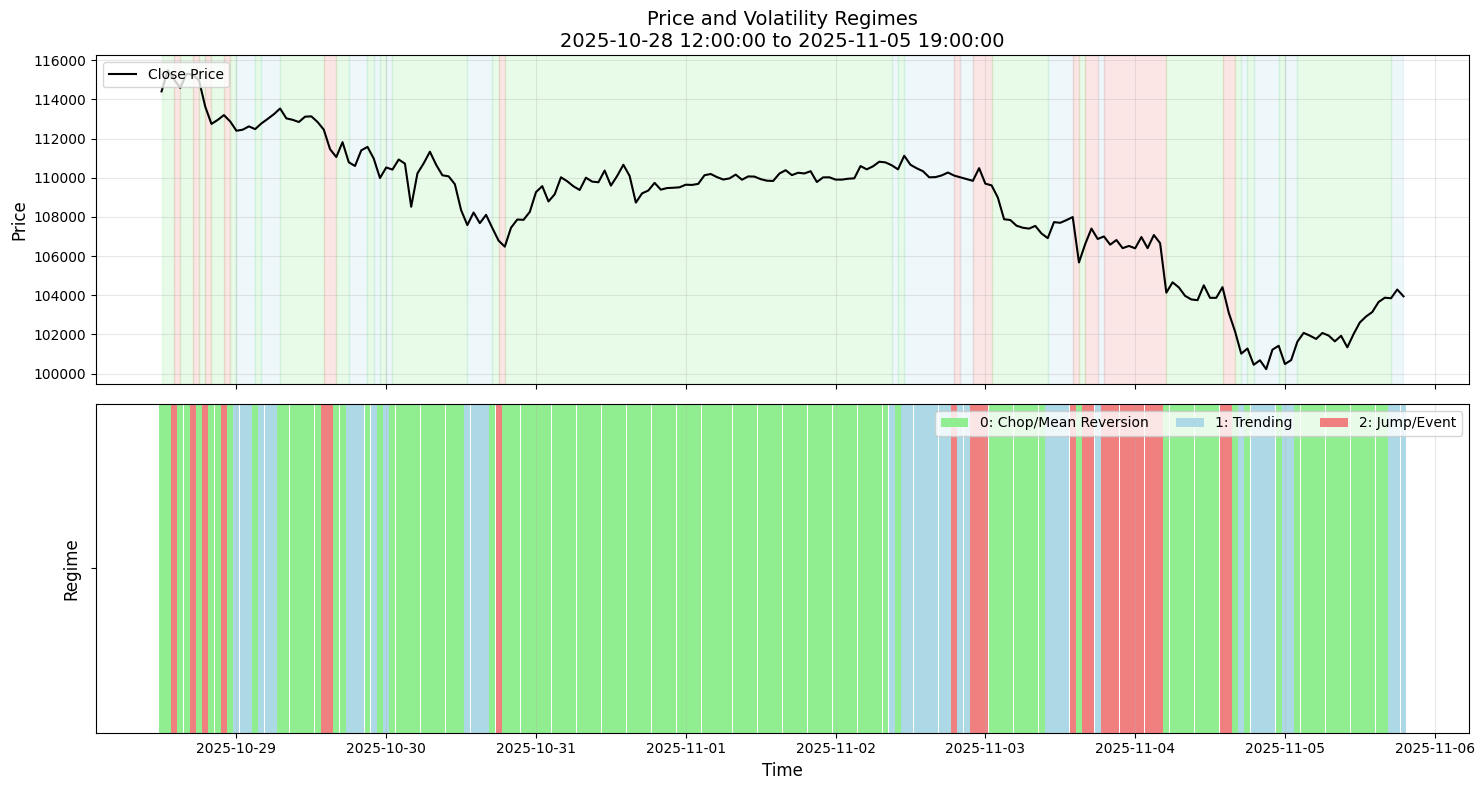


Period: 2025-10-28 12:00:00 to 2025-11-05 19:00:00
Regime distribution:
  Class 0 (Chop/Mean Reversion): 133 hours (66.5%)
  Class 1 (Trending): 41 hours (20.5%)
  Class 2 (Jump/Event): 26 hours (13.0%)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random 1-month period (720 hours)
total_rows = len(targets)
if total_rows > 200:
    start_idx = np.random.randint(0, total_rows - 200)
    end_idx = start_idx + 200
else:
    start_idx = 0
    end_idx = total_rows

# Slice data for the period
period_data = features.iloc[start_idx:end_idx].copy()
period_targets = targets.iloc[start_idx:end_idx].copy()

# Get price and regime
price = period_data['c'] if 'c' in period_data.columns else period_data.index.to_series()
regime = period_targets['regime_label']

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot 1: Price with regime background colors
ax1.plot(price.index, price.values, color='black', linewidth=1.5, label='Close Price')
ax1.set_ylabel('Price', fontsize=12)
ax1.set_title(f'Price and Volatility Regimes\n{price.index[0]} to {price.index[-1]}', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Add colored background for regimes
regime_colors = {0: 'lightgreen', 1: 'lightblue', 2: 'lightcoral'}
regime_labels = {0: 'Chop/Mean Reversion', 1: 'Trending', 2: 'Jump/Event'}

y_min, y_max = ax1.get_ylim()
current_regime = None
start_x = None

for i, (idx, reg) in enumerate(regime.items()):
    if pd.notna(reg):
        reg = int(reg)
        if reg != current_regime:
            # End previous regime block
            if current_regime is not None and start_x is not None:
                ax1.axvspan(start_x, idx, alpha=0.2, color=regime_colors.get(current_regime, 'white'))
            # Start new regime block
            current_regime = reg
            start_x = idx
            
# Fill last regime block
if current_regime is not None and start_x is not None:
    ax1.axvspan(start_x, regime.index[-1], alpha=0.2, color=regime_colors.get(current_regime, 'white'))

# Plot 2: Regime as colored bars
regime_numeric = regime.fillna(-1)
colors = [regime_colors.get(int(r), 'gray') if r >= 0 else 'gray' for r in regime_numeric]

ax2.bar(regime.index, [1]*len(regime), color=colors, width=0.04, edgecolor='none')
ax2.set_ylabel('Regime', fontsize=12)
ax2.set_yticks([0.5])
ax2.set_yticklabels([''])
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='x')

# Add legend for regimes
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=regime_colors[0], label='0: Chop/Mean Reversion'),
                   Patch(facecolor=regime_colors[1], label='1: Trending'),
                   Patch(facecolor=regime_colors[2], label='2: Jump/Event')]
ax2.legend(handles=legend_elements, loc='upper right', ncol=3)

plt.xlabel('Time', fontsize=12)
plt.tight_layout()
plt.show()

# Print some stats for this period
print(f"\nPeriod: {price.index[0]} to {price.index[-1]}")
print(f"Regime distribution:")
regime_counts = regime.value_counts().sort_index()
for reg, count in regime_counts.items():
    if pd.notna(reg):
        reg_int = int(reg)
        pct = count / len(regime) * 100
        print(f"  Class {reg_int} ({regime_labels.get(reg_int, 'Unknown')}): {count} hours ({pct:.1f}%)")
